# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [ ]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [ ]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

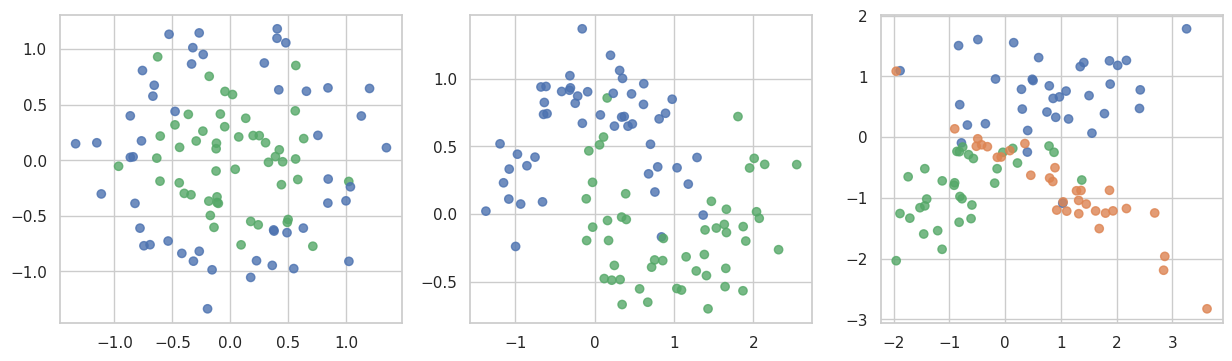

In [ ]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [ ]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

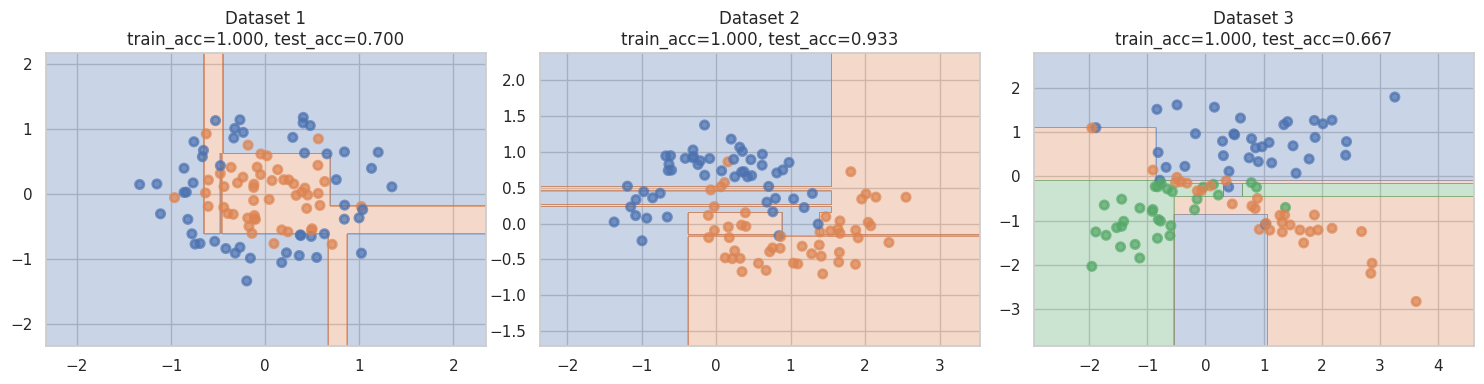

Dataset 1: train_acc=1.000, test_acc=0.700
Dataset 2: train_acc=1.000, test_acc=0.933
Dataset 3: train_acc=1.000, test_acc=0.667


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

tree_clfs = []
results = []

plt.figure(figsize=(15, 4))

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    tree_clfs.append(clf)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    results.append((train_acc, test_acc))

    plt.subplot(1, 3, i + 1)
    plot_surface(clf, X, y)
    plt.title(
        f"Dataset {i+1}\n"
        f"train_acc={train_acc:.3f}, test_acc={test_acc:.3f}"
    )

plt.tight_layout()
plt.show()

for i, (train_acc, test_acc) in enumerate(results):
    print(f"Dataset {i+1}: train_acc={train_acc:.3f}, test_acc={test_acc:.3f}")

__Ответ:__

На всех трёх датасетах дерево переобучается: train accuracy = 1.0, а test accuracy заметно ниже

Особенно сильно это видно на нелинейных задачах (circles, 3-классовый датасет). Модель плохо обобщает.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?


===== DATASET 1 =====


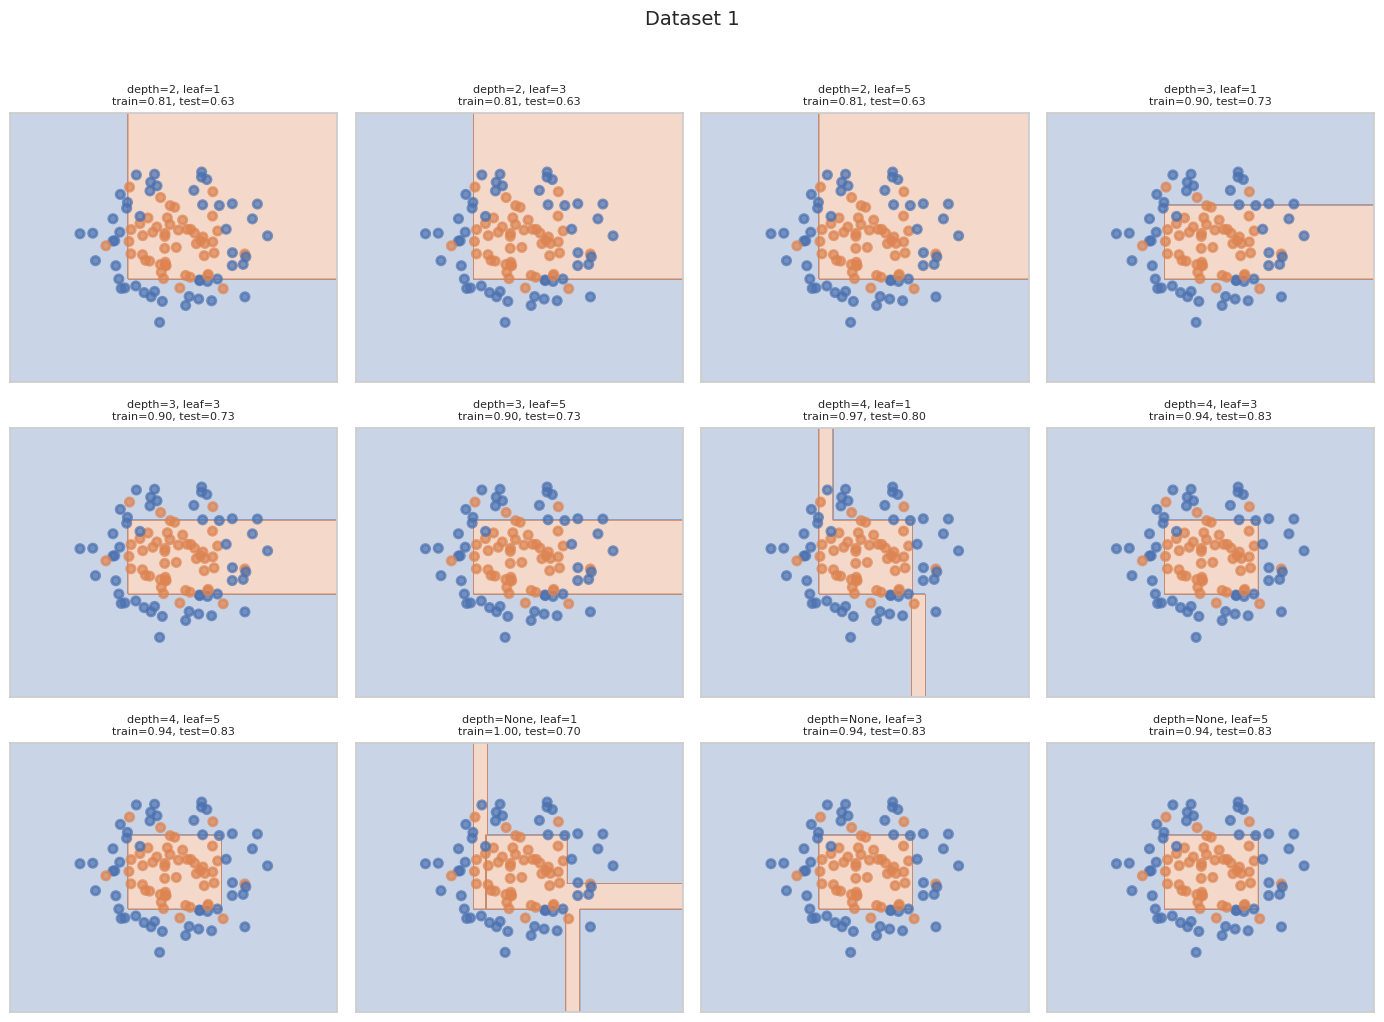

,max_depth,min_samples_leaf,train_acc,test_acc
8,4.0,5,0.942857,0.833333
10,NaN,3,0.942857,0.833333
11,NaN,5,0.942857,0.833333
7,4.0,3,0.942857,0.833333
6,4.0,1,0.971429,0.800000



===== DATASET 2 =====


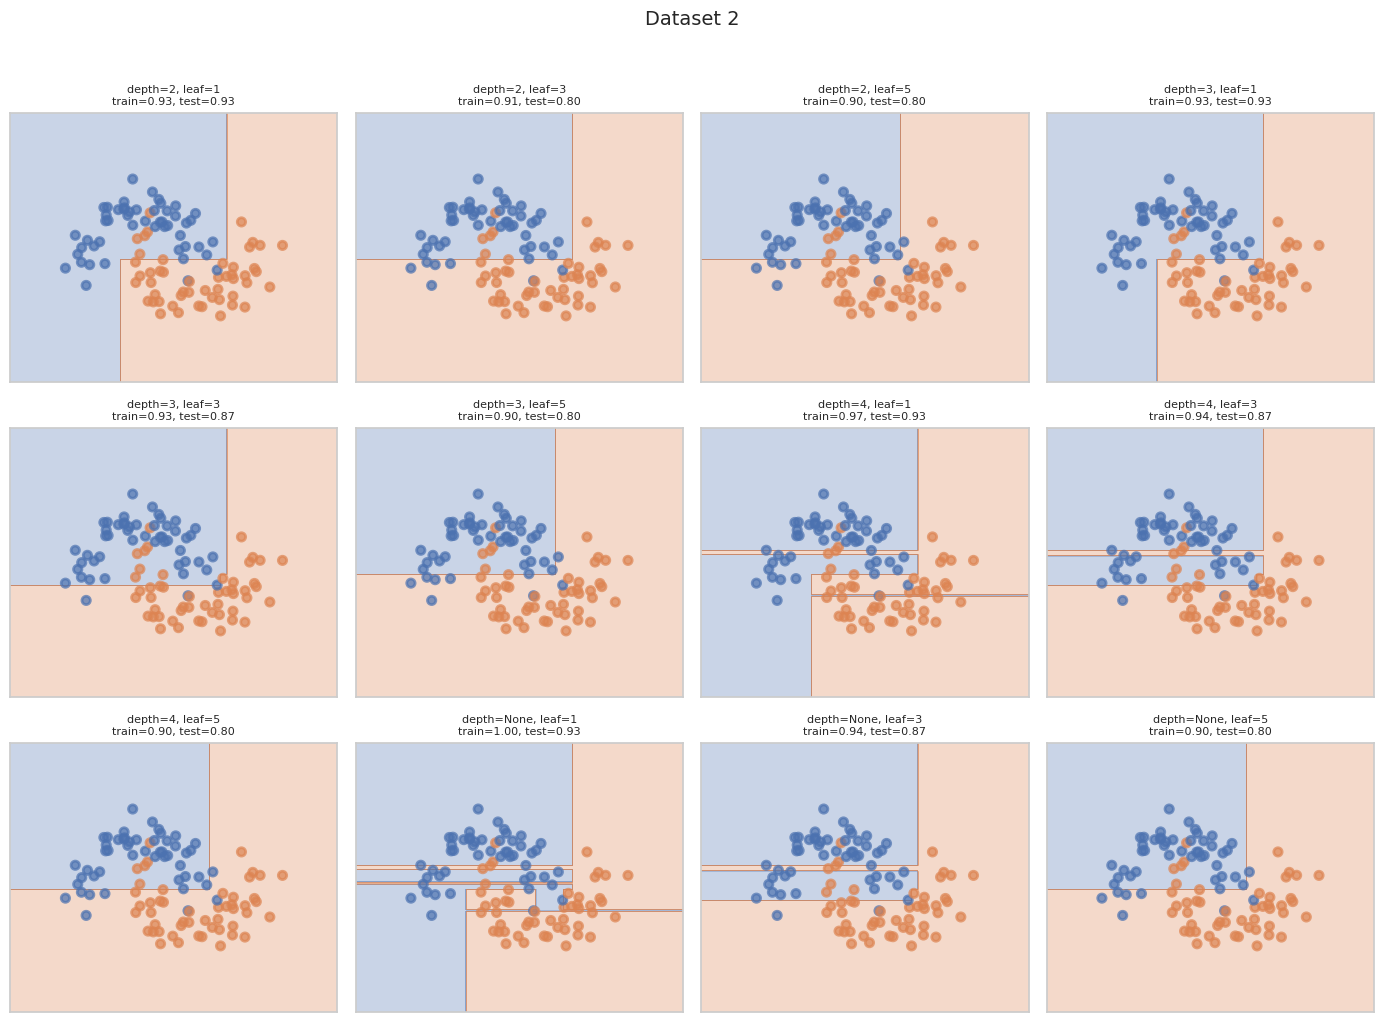

,max_depth,min_samples_leaf,train_acc,test_acc
0,2.0,1,0.928571,0.933333
3,3.0,1,0.928571,0.933333
9,NaN,1,1.000000,0.933333
6,4.0,1,0.971429,0.933333
10,NaN,3,0.942857,0.866667



===== DATASET 3 =====


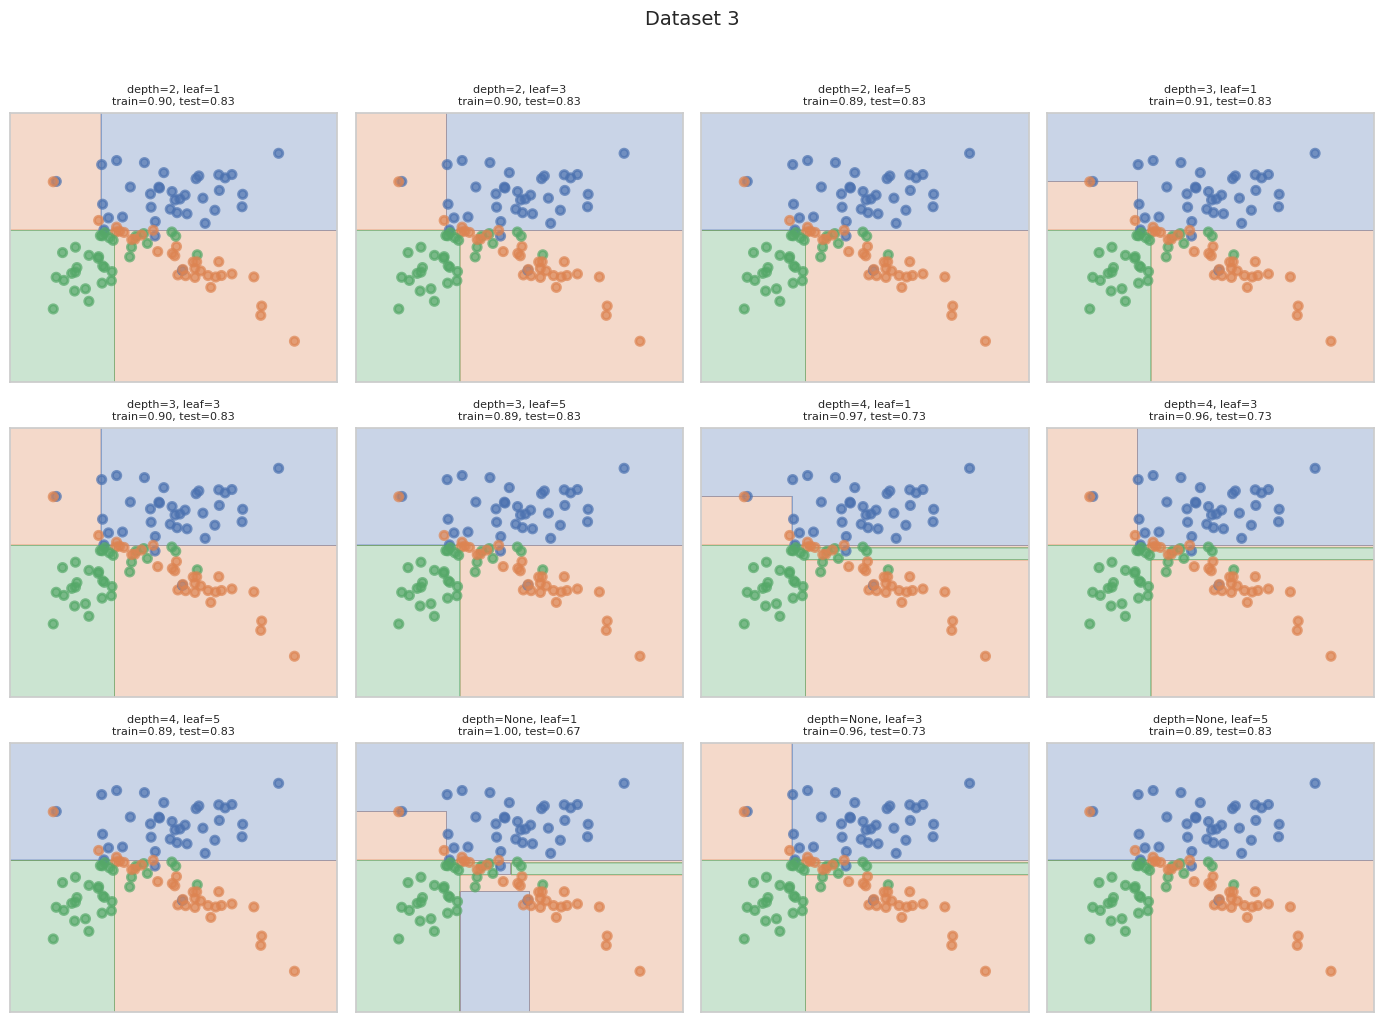

,max_depth,min_samples_leaf,train_acc,test_acc
0,2.0,1,0.900000,0.833333
1,2.0,3,0.900000,0.833333
2,2.0,5,0.885714,0.833333
3,3.0,1,0.914286,0.833333
4,3.0,3,0.900000,0.833333


In [ ]:
from sklearn.metrics import accuracy_score
import itertools

max_depth_list = [2, 3, 4, None]
min_leaf_list = [1, 3, 5]

def run_experiment(X, y, dataset_name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    results = []

    plt.figure(figsize=(14, 10))
    plot_id = 1

    for depth, leaf in itertools.product(max_depth_list, min_leaf_list):
        clf = DecisionTreeClassifier(
            max_depth=depth,
            min_samples_leaf=leaf,
            random_state=42
        )
        clf.fit(X_train, y_train)

        train_acc = accuracy_score(y_train, clf.predict(X_train))
        test_acc = accuracy_score(y_test, clf.predict(X_test))

        results.append({
            "max_depth": depth,
            "min_samples_leaf": leaf,
            "train_acc": train_acc,
            "test_acc": test_acc
        })

        plt.subplot(len(min_leaf_list), len(max_depth_list), plot_id)
        plot_surface(clf, X, y)
        plt.title(f"depth={depth}, leaf={leaf}\n"
                  f"train={train_acc:.2f}, test={test_acc:.2f}",
                  fontsize=8)
        plt.xticks([]); plt.yticks([])
        plot_id += 1

    plt.suptitle(dataset_name, y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(results)


for i, (X, y) in enumerate(datasets):
    print(f"\n===== DATASET {i+1} =====")
    df_res = run_experiment(X, y, f"Dataset {i+1}")
    display(df_res.sort_values("test_acc", ascending=False).head())

__Ответ:__

На всех датасетах добавление регуляризации снижает переобучение: train accuracy становится ниже, но test accuracy растёт и становится стабильнее

Уменьшение max_depth и увеличение min_sampls_leaf делают разделяющую поверхность более гладкой, что особенно улучшает качество на сложных датасетах как 1 и 3

При этом нелинейный датасет make_moons почти не страдает от небольшй регуляризации. его test accuracy остаётся на уровне 0.93

Хорошие параметры различаются между датасетами, но во всех случаях регуляризация делает модель более устойчивой и лучше обобщающей

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

In [9]:
# написал весь код из файла сюда для простоты

import numpy as np
from collections import Counter


def find_best_split(feature_vector, target_vector):
    """
    Под критерием Джини здесь подразумевается следующая функция:
    $$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
    $R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-п_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух соседних (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """

    x = feature_vector
    y = target_vector
    n = len(x)

    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]

    mask = x_sorted[1:] != x_sorted[:-1]
    if not np.any(mask):
        return np.array([]), np.array([]), None, None

    thresholds = (x_sorted[1:][mask] + x_sorted[:-1][mask]) / 2

    y_cumsum = np.cumsum(y_sorted)
    total_ones = y_cumsum[-1]

    left_sizes = np.arange(1, n)[mask]
    right_sizes = n - left_sizes

    left_ones = y_cumsum[left_sizes - 1]
    right_ones = total_ones - left_ones

    left_p1 = left_ones / left_sizes
    left_p0 = 1 - left_p1
    right_p1 = right_ones / right_sizes
    right_p0 = 1 - right_p1

    g_left = 1 - left_p1**2 - left_p0**2
    g_right = 1 - right_p1**2 - right_p0**2

    ginis = -(left_sizes / n) * g_left - (right_sizes / n) * g_right

    best_idx = np.argmax(ginis)
    gini_best = ginis[best_idx]
    threshold_best = thresholds[best_idx]

    return thresholds, ginis, threshold_best, gini_best


class DecisionTree:
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split if min_samples_split is not None else 2
        self._min_samples_leaf = min_samples_leaf if min_samples_leaf is not None else 1

    def _fit_node(self, sub_X, sub_y, node, depth=0):

        if self._max_depth is not None and depth >= self._max_depth:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        if len(sub_y) < self._min_samples_split:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, split_best, gini_best = None, None, None, -np.inf

        for feature in range(sub_X.shape[1]):

            feature_type = self._feature_types[feature]
            feature_vector = sub_X[:, feature]

            if feature_type == "categorical":
                categories = np.unique(feature_vector)
                means = [np.mean(sub_y[feature_vector == c]) for c in categories]
                sorted_vals = [c for _, c in sorted(zip(means, categories))]
                mapping = {v: i for i, v in enumerate(sorted_vals)}
                feature_vector = np.array([mapping[v] for v in feature_vector])

            thresholds, ginis, thr_best, gini_local_best = find_best_split(feature_vector, sub_y)

            if thr_best is None:
                continue

            if gini_local_best > gini_best:
                gini_best = gini_local_best
                feature_best = feature
                threshold_best = thr_best
                split_best = feature_vector < thr_best
                best_feature_type = feature_type
                if feature_type == "categorical":
                    best_categories = [v for v in mapping if mapping[v] < thr_best]

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        if split_best.sum() < self._min_samples_leaf or (~split_best).sum() < self._min_samples_leaf:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best

        if best_feature_type == "real":
            node["threshold"] = threshold_best
        else:
            node["categories_split"] = best_categories

        node["left_child"] = {}
        node["right_child"] = {}

        self._fit_node(sub_X[split_best], sub_y[split_best], node["left_child"], depth + 1)
        self._fit_node(sub_X[~split_best], sub_y[~split_best], node["right_child"], depth + 1)

    def _predict_node(self, x, node):
        if node["type"] == "terminal":
            return node["class"]

        feature = node["feature_split"]

        if "threshold" in node:
            if x[feature] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

        else:
            if x[feature] in node["categories_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def fit(self, X, y):
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)


__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [19]:
df = pd.read_excel(
    "gdrive/My Drive/Colab Notebooks/data_user_modeling.xls",
    sheet_name="Training_Data",
    usecols=[0, 1, 2, 3, 4, 5]  # A:F
)

print(df.head())
print(df.keys())

df["UNS"] = df[" UNS"]
df.drop(columns=[" UNS"], inplace=True)

# у меня в целевой переменной лежит класс от very_low до High, считаю целевым классом very_low
df["UNS"] = (df["UNS"] != "very_low").astype(int)

X = df.iloc[:, :5].values
y = df["UNS"].values
feature_names = df.columns[:5]

    STG   SCG   STR   LPR   PEG       UNS
0  0.00  0.00  0.00  0.00  0.00  very_low
1  0.08  0.08  0.10  0.24  0.90      High
2  0.06  0.06  0.05  0.25  0.33       Low
3  0.10  0.10  0.15  0.65  0.30    Middle
4  0.08  0.08  0.08  0.98  0.24       Low
Index(['STG', 'SCG', 'STR', 'LPR', 'PEG', ' UNS'], dtype='object')


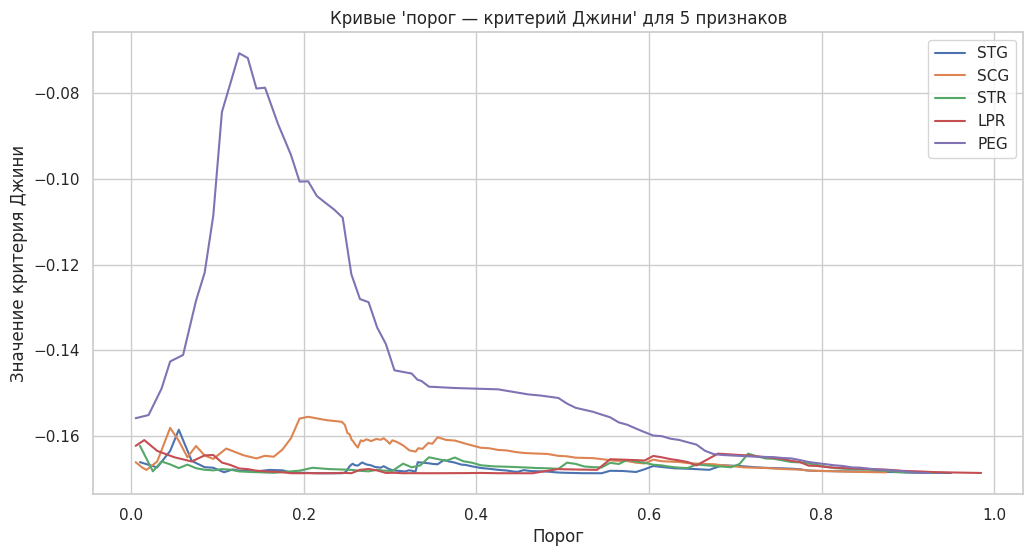

In [20]:
plt.figure(figsize=(12, 6))

for i in range(5):
    feature_vector = X[:, i].astype(float)
    thresholds, ginis, best_t, best_g = find_best_split(feature_vector, y)
    plt.plot(thresholds, ginis, label=feature_names[i])

plt.xlabel("Порог")
plt.ylabel("Значение критерия Джини")
plt.title("Кривые 'порог — критерий Джини' для 5 признаков")
plt.legend()
plt.grid(True)
plt.show()

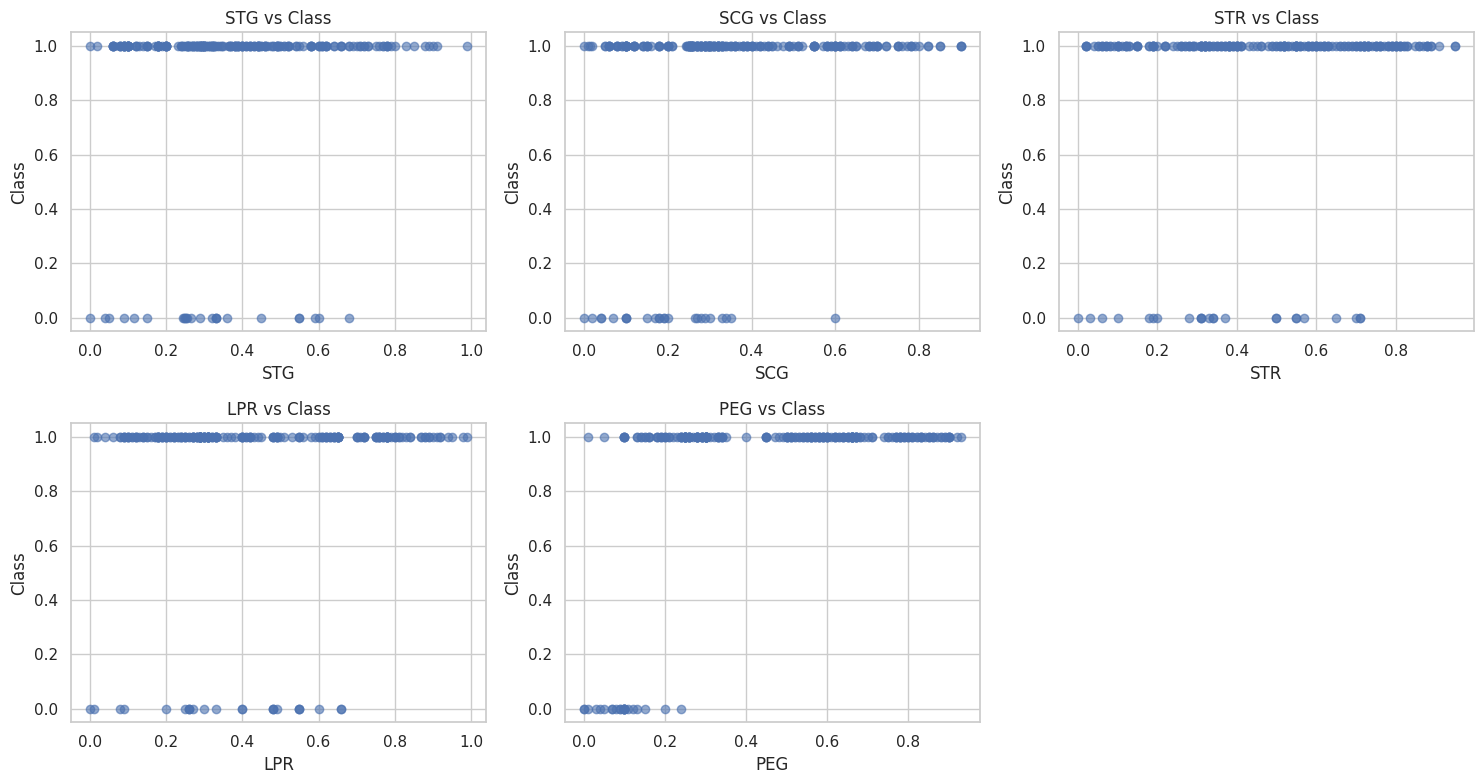

In [21]:
plt.figure(figsize=(15, 8))

for i in range(5):
    plt.subplot(2, 3, i + 1)
    plt.scatter(X[:, i], y, alpha=0.6)
    plt.xlabel(feature_names[i])
    plt.ylabel("Class")
    plt.title(f"{feature_names[i]} vs Class")
    plt.grid(True)

plt.tight_layout()
plt.show()


__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**

Лучшим признаком для разбиения является PEG. Его кривая Джини заметно выше остальных, и это полностью совпадает со scatter-графиком, где классы хорошо разделяются по этому признаку

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv("gdrive/My Drive/Colab Notebooks/agaricus-lepiota.data", header=None)

y_raw = df.iloc[:, 0]
X_raw = df.iloc[:, 1:]

encoders = []
X = np.zeros_like(X_raw)

for i, col in enumerate(X_raw.columns):
    le = LabelEncoder()
    X[:, i] = le.fit_transform(X_raw[col])
    encoders.append(le)

le_y = LabelEncoder()
y = le_y.fit_transform(y_raw)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

feature_types = ["categorical"] * X.shape[1]
tree = DecisionTree(feature_types)

tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)


Accuracy: 1.0


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [23]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SklearnDecisionTreeAdapter(BaseEstimator, ClassifierMixin):
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        self.feature_types = feature_types
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def fit(self, X, y):
        self.model_ = DecisionTree(
            feature_types=self.feature_types,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
        )
        self.model_.fit(X, y)
        return self

    def predict(self, X):
        return self.model_.predict(X)


In [25]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier

paths = {
    "mushrooms": "gdrive/My Drive/Colab Notebooks/agaricus-lepiota.data",
    "tic-tac-toe": "gdrive/My Drive/Colab Notebooks/tic-tac-toe.data",
    "cars": "gdrive/My Drive/Colab Notebooks/car.data",
    "nursery": "gdrive/My Drive/Colab Notebooks/nursery.data",
}

def load_mushrooms(path):
    df = pd.read_csv(path, header=None)
    y_raw = df.iloc[:, 0]
    X_raw = df.iloc[:, 1:]

    # LabelEncoder по каждому столбцу X
    X = np.zeros_like(X_raw, dtype=int)
    for i, col in enumerate(X_raw.columns):
        le = LabelEncoder()
        X[:, i] = le.fit_transform(X_raw[col])

    le_y = LabelEncoder()
    y = le_y.fit_transform(y_raw)
    return X, y

def load_tictactoe(path):
    df = pd.read_csv(path, header=None)
    X_raw = df.iloc[:, :-1]
    y_raw = df.iloc[:, -1]

    X = np.zeros_like(X_raw, dtype=int)
    for i, col in enumerate(X_raw.columns):
        le = LabelEncoder()
        X[:, i] = le.fit_transform(X_raw[col])

    le_y = LabelEncoder()
    y = le_y.fit_transform(y_raw)
    return X, y

def load_cars(path):
    df = pd.read_csv(path, header=None)
    X_raw = df.iloc[:, :-1]
    y_raw = df.iloc[:, -1]

    X = np.zeros_like(X_raw, dtype=int)
    for i, col in enumerate(X_raw.columns):
        le = LabelEncoder()
        X[:, i] = le.fit_transform(X_raw[col])

    # unacc, acc -> 0; good, vgood -> 1
    y = np.isin(y_raw, ["good", "vgood"]).astype(int)
    return X, y

def load_nursery(path):
    df = pd.read_csv(path, header=None)
    X_raw = df.iloc[:, :-1]
    y_raw = df.iloc[:, -1]

    X = np.zeros_like(X_raw, dtype=int)
    for i, col in enumerate(X_raw.columns):
        le = LabelEncoder()
        X[:, i] = le.fit_transform(X_raw[col])

    # not_recom, recommend -> 0; very_recom, priority, spec_prior -> 1
    y = np.isin(y_raw, ["very_recom", "priority", "spec_prior"]).astype(int)
    return X, y

loaders = {
    "mushrooms": load_mushrooms,
    "tic-tac-toe": load_tictactoe,
    "cars": load_cars,
    "nursery": load_nursery,
}


In [28]:
scorer = make_scorer(accuracy_score)

results = []

for name in ["mushrooms", "tic-tac-toe", "cars", "nursery"]:
    print(f"=== {name} ===")
    X, y = loaders[name](paths[name])

    feat_real = ["real"] * X.shape[1]
    clf_real = SklearnDecisionTreeAdapter(feature_types=feat_real)
    acc_real = cross_val_score(clf_real, X, y, cv=10, scoring=scorer).mean()

    feat_cat = ["categorical"] * X.shape[1]
    clf_cat = SklearnDecisionTreeAdapter(feature_types=feat_cat)
    acc_cat = cross_val_score(clf_cat, X, y, cv=10, scoring=scorer).mean()

    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    X_ohe = ohe.fit_transform(X)
    feat_real_ohe = ["real"] * X_ohe.shape[1]
    clf_real_ohe = SklearnDecisionTreeAdapter(feature_types=feat_real_ohe)
    acc_real_ohe = cross_val_score(clf_real_ohe, X_ohe, y, cv=10, scoring=scorer).mean()

    sk_clf = DecisionTreeClassifier(random_state=42)
    acc_sk = cross_val_score(sk_clf, X, y, cv=10, scoring=scorer).mean()

    results.append({
        "dataset": name,
        "DT_real": acc_real,
        "DT_categorical": acc_cat,
        "DT_real_OHE": acc_real_ohe,
        "sklearn_DT": acc_sk,
    })

df_results = pd.DataFrame(results).set_index("dataset")
df_results


=== mushrooms ===
=== tic-tac-toe ===
=== cars ===
=== nursery ===


,DT_real,DT_categorical,DT_real_OHE,sklearn_DT
dataset,,,,
mushrooms,0.999261,1.000000,0.999631,0.960384
tic-tac-toe,0.467533,0.541458,0.543575,0.771678
cars,0.942647,0.967546,0.919495,0.942707
nursery,0.999691,0.999846,0.999537,0.999691


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Лучше всего у меня работает дерево с категорическими признаками. Его качество на mushrooms, cars и nursery почти идеально. На tic-tac-toe лучше выступает sklearn, потому что модель умеет строить более агрессивные и глубокие разбиения, а моя реализация нет. Общая идея такая: когда данные по сути категориальные, "категориальный" режим дерева работает лучше любых one-hot и вещественных кодировок.



Вставьте что угодно, описывающее ваши впечатления от этого задания:

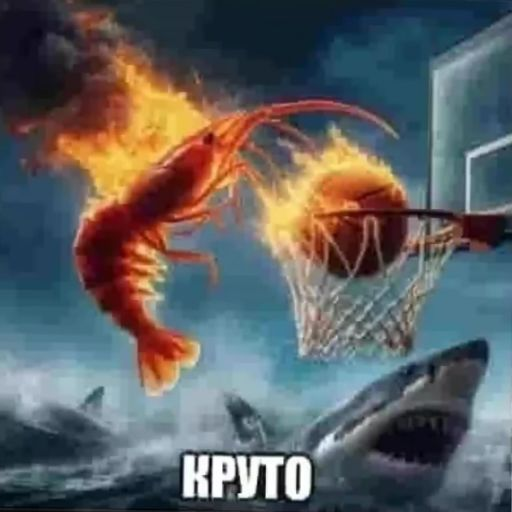